<a class="reference external" href="https://jupyter.designsafe-ci.org/hub/user-redirect/lab/tree/CommunityData/Training/Computational-Workflows-on-DesignSafe/Jupyter_Notebooks/Jupyter_Notebooks_AgnosticApp_MLexample/DS_Agnostic_App_Submit_MLExample.ipynb" target="_blank">
<img alt="Try on DesignSafe" src="https://raw.githubusercontent.com/DesignSafe-Training/pinn/main/DesignSafe-Badge.svg" /></a>

# Machine-Learning Example
**Creating the Input and Running the *designsafe-agnostic-app* for an MPI-Based Machine-Learning Workflow**
*Silvia Mazzoni, 2026*


This notebook walks through the complete process of submitting a **Tapis job** using the **designsafe-agnostic-app**. We start by examining the app schema, then build a job input that conforms to that schema, and finally submit the job programmatically.

To streamline this process, we use a small **Python utility function** that assembles input arguments in a way that is consistent with the app’s expected structure. This approach reduces boilerplate, minimizes errors, and makes it easier to repeat or automate submissions.

The workflow used in this example is **not intended to represent a final scientific study**. Instead, it is designed to be *realistic*—large enough to reflect common research patterns, but focused on demonstrating how an MPI-style, machine-learning–type job can be executed through the agnostic app.

You will notice that large data files are **copied into the job working directory from an existing location** (rather than staged directly through Tapis inputs) and are **deleted at the end of the job**. This pattern is recommended for large datasets, as it avoids unnecessary data movement through the Tapis system, which can be slow and inefficient for repeated or large transfers.


The agnostic app can also be accessed through the DesignSafe web portal:

* [https://designsafe-ci.org/workspace/designsafe-agnostic-app](https://designsafe-ci.org/workspace/designsafe-agnostic-app)

While submitting jobs through the portal is not ideal for repeated or automated runs, the portal view is extremely useful for understanding the app. It presents all inputs with descriptions, defaults, and allowed options, making it a valuable reference when developing programmatic submissions such as the one shown here.


## This Noteook
This notebook runs a single MPI-enabled script that **always computes waveform metrics and trains a regression model**.

You control **how much ML output is saved and visualized** via command-line flags.

If ML artifacts are written, they are automatically merged and plotted during post-processing; if not, the workflow behaves like a metrics-only analysis.

## ML Example Workflow (Single Script)

This notebook uses a **single MPI-enabled script**,
`nga_mpi_ml_example.py`, to run a combined **metrics + RotD + machine-learning** workflow.
All runs follow the same computational path; the difference is **whether ML artifacts are written and post-processed**, not whether ML logic is executed.

In other words: the script always computes waveform metrics and trains a regression model, but you can choose how much of the ML output you want to keep and analyze.

---

### Core Processing (always performed)

Every run of `nga_mpi_ml_example.py` performs the following steps:

* Reads the NGA flatfile (`.xlsx`) to obtain metadata such as:
  Mw, Vs30, distances, PGA/PGV, Tp, etc.
* Uses the filename-mapping CSV (`.csv`) to locate **H1 and H2** waveform datasets inside the merged NGA HDF5 file.
* Loads waveform time series from HDF5 and computes time-domain metrics, including:

  * `amax`, `amin`, `amp_range`
  * `dt_peaks`, `dt_peaks_norm`, duration
* Optionally computes **time-domain RotD summaries** (RotD0, RotD50, RotD100) using H1/H2 rotations.
* Distributes RSNs across MPI ranks using `mpi4py`.
* Writes per-component outputs (H1 and H2):

  * metrics tables
  * processed / skipped logs

These steps happen **regardless of whether you later use the ML results**.

---

### Machine-Learning Layer (always executed, optionally persisted)

After metrics are computed, the script builds a simple regression model that:

* Constructs a feature matrix from flatfile predictors
  (e.g., Mw, distances, Vs30, PGA/PGV, Tp)
* Predicts a waveform-derived target quantity
  (typically `amp_range`)
* Handles missing predictors according to a user-selected strategy:

  * `--ml-missing drop`
    Drop rows with missing predictors
  * `--ml-missing impute`
    Median-impute missing values and add missing-indicator features
* Optionally screens extreme amplitudes **for ML only**
  (records are still kept in the metrics tables)

You may optionally:

* split the data into train/test sets
* write per-record predictions and residuals
* serialize the fitted model for later reuse

---

### Required inputs (all runs)

* Flatfile Excel:
  `--flatfile-xlsx <flatfileFN>`
* Filename-mapping CSV:
  `--filenames-csv <filepathMapFN>`
* Waveform HDF5 file:
  `--hdf5 <hdf5Filename>`
* Output controls:
  `--outdir <outDir>` and `--out-prefix <outPrefix>`
* MPI enabled:
  the script uses `mpi4py` to distribute RSNs across ranks

---

### Common runtime options

* `--compute-rotd`
  Enable RotD0 / RotD50 / RotD100 computation
* `--rotd-angle-step <float>`
  Angular resolution for RotD (degrees)
* `--limit <int>`
  Optional RSN limit for debugging or testing

---

### ML-specific options (control outputs, not execution)

* `--ml-missing drop|impute`
  Missing-data strategy for predictors
* `--test-frac <float>` and `--seed <int>`
  Train/test split configuration
* `--max-abs-amp <float>`
  ML-only outlier screening threshold
* `--write-preds`
  Write per-record predictions and residuals
* `--save-model json|joblib|none`
  Serialize the fitted model

---

### Post-processing note

If ML predictions are written (via `--write-preds`), the extended post-processing script can automatically:

* merge ML predictions and residuals into the combined metrics table
* add ML diagnostic pages (predicted vs. true, residual histograms) to the PDF report
* capture ML summary statistics in a JSON file

If ML artifacts are not written, post-processing gracefully falls back to a **metrics-only report** without any ML pages.

---

## How the notebook inputs map to the job

This notebook constructs the agnostic-app job using the following inputs:

* **Program**
  `myMainProgram = 'python3'`

* **Main script**
  `myMainScript = 'nga_mpi_ml_example.py'`

* **MPI control**
  `myUseMPI = 'True'`
  (the script internally uses `mpi4py`)

* **Data locations**

  * Storage system: `myStorageSystem`
  * Input folder: `myInputFolder`
  * Dataset conventions:

    * `WorkPath_local = '~/Work/stampede3'`
    * `WorkPath_hpc = '$WORK'`
    * `DatasetPath = 'Datasets/NGAWest2'`

* **Data files**

  * Flatfile: `flatfileFN`
  * Filename mapping: `filepathMapFN`
  * Waveforms: `hdf5Filename`

* **Run controls**

  * Missing-data strategy: `MLmissing = 'impute'` (`'impute'` or `'drop'`)
  * Output controls: `outDir`, `outPrefix`
  * RotD toggle: `computeRotDTXT` (`'--compute-rotd'` or `''`)
  * Debugging limit: `limit` (`-1` for no limit)



## What flags control and which outputs are produced
    
The table below summarizes how the most important options affect the outputs of the run.
All runs use the same script: `nga_mpi_ml_example.py`.

| Feature / Output          | Controlled by                     | What happens                                                                                                   |                                                                                                      |                                                            |
| ------------------------- | --------------------------------- | -------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- | ---------------------------------------------------------- |
| Waveform metrics (H1/H2)  | *(always on)*                     | Time-domain metrics are computed for every valid RSN and written to `*_metrics_H1.csv` and `*_metrics_H2.csv`. |                                                                                                      |                                                            |
| Processed / skipped logs  | *(always on)*                     | Each component gets a processed and skipped log explaining dataset availability or errors.                     |                                                                                                      |                                                            |
| RotD0 / RotD50 / RotD100  | `--compute-rotd`                  | If enabled, time-domain RotD summaries are computed from H1/H2 rotations and written to `*_metrics_RotD.csv`.  |                                                                                                      |                                                            |
| ML feature construction   | *(always on)*                     | Flatfile predictors are assembled into a feature matrix after metrics are computed.                            |                                                                                                      |                                                            |
| Missing-data handling     | `--ml-missing drop                | impute`                                                                                                        | Controls whether rows with missing predictors are dropped or median-imputed with missing indicators. |                                                            |
| Train/test split          | `--test-frac`, `--seed`           | If provided, data are split into training and testing subsets for ML diagnostics.                              |                                                                                                      |                                                            |
| ML-only outlier screening | `--max-abs-amp`                   | Records exceeding this threshold are excluded **from ML only**, but remain in the metrics tables.              |                                                                                                      |                                                            |
| Per-record predictions    | `--write-preds`                   | Writes `*_ml_preds_H1.csv` / `*_ml_preds_H2.csv` with `y`, `yhat`, residuals, and train/test labels.           |                                                                                                      |                                                            |
| Serialized ML model       | `--save-model json                | joblib                                                                                                         | none`                                                                                                | Saves the fitted regression model for reuse or inspection. |
| ML diagnostics in PDF     | `--write-preds` (post-processing) | If predictions exist, post-processing adds predicted-vs-true and residual pages to the PDF report.             |                                                                                                      |                                                            |
| ML summary JSON           | `--write-preds` (post-processing) | Parsed ML report statistics are saved to `<prefix>_ml_summary.json`.                                           |                                                                                                      |                                                            |

---

## Practical guidance for users

* **If you just want metrics and RotD:**
  Run the script without `--write-preds` and `--save-model`.
  ML still runs internally, but no ML artifacts are written or visualized.

* **If you want full ML diagnostics and reproducibility:**
  Include `--write-preds` and `--save-model json` (recommended).
  The post-processor will automatically merge predictions and add ML pages to the report.

* **For training and demonstrations:**
  Keeping ML artifacts enabled is usually preferable — it shows how metrics, ML, and post-processing connect without requiring a second script.


## Recommended default flags

For most users and training runs, **this is the recommended baseline**.
It produces metrics, RotD summaries, ML diagnostics, and post-processing–ready outputs without overthinking options.

```python
# Recommended defaults for most runs
testFrac   = 0.20
seed       = 12345
maxAbsAmp  = 10.0
saveModel  = "json"     # portable, human-readable

myCommandLineArgs = f'--flatfile-xlsx {flatfileFN} \
  --filenames-csv {filepathMapFN} \
  --hdf5 {hdf5Filename} \
  --out-prefix {outPrefix} \
  --outdir {outDir} \
  --limit {limit} \
  {computeRotDTXT} \
  --ml-missing {MLmissing} \
  --test-frac {testFrac} \
  --seed {seed} \
  --max-abs-amp {maxAbsAmp} \
  --write-preds \
  --save-model {saveModel}'
```

### When to change these defaults

* **Large production runs:** keep everything as-is
* **Quick debugging:** set `limit = 50` or `limit = 200`
* **Exploring missing metadata:** try `MLmissing = 'drop'` vs `'impute'`
* **You don’t care about ML outputs:** remove `--write-preds` and `--save-model`



## Workflow overview: from metrics to ML to post-processing

The figure below summarizes how data flows through the workflow when using
`nga_mpi_ml_example.py` with the DesignSafe agnostic app.

```
┌──────────────────────────────┐
│  NGA Flatfile (.xlsx)        │
│  Mw, Vs30, distances, etc.   │
└──────────────┬───────────────┘
               │
┌──────────────▼───────────────┐
│ Filename Mapping (.csv)      │
│ RSN → H1 / H2 dataset names  │
└──────────────┬───────────────┘
               │
┌──────────────▼───────────────┐
│ Waveform HDF5 (.hdf5)        │
│ H1 / H2 time series          │
└──────────────┬───────────────┘
               │
               ▼
┌──────────────────────────────┐
│ MPI Processing (mpi4py)      │
│ • RSNs distributed to ranks │
│ • Metrics computed per RSN  │
│ • Optional RotD summaries   │
└──────────────┬───────────────┘
               │
               ▼
┌──────────────────────────────┐
│ Metrics Outputs              │
│ *_metrics_H1.csv             │
│ *_metrics_H2.csv             │
│ *_metrics_RotD.csv (opt)     │
│ processed / skipped logs     │
└──────────────┬───────────────┘
               │
               ▼
┌──────────────────────────────┐
│ Machine Learning Layer       │
│ • Feature matrix from        │
│   flatfile predictors        │
│ • Missing-data handling      │
│ • Train/test split           │
│ • Regression fit             │
└──────────────┬───────────────┘
               │
               ▼
┌──────────────────────────────┐
│ Optional ML Artifacts        │
│ *_ml_preds_H1.csv / H2.csv   │
│ *_ml_report_H1.txt / H2.txt  │
│ *_model_H1.json / H2.json    │
└──────────────┬───────────────┘
               │
               ▼
┌──────────────────────────────┐
│ Post-Processing              │
│ • Merge metrics + ML preds   │
│ • Histograms & scatter plots │
│ • ML diagnostic pages (opt)  │
│ • Final PDF + summary JSON   │
└──────────────────────────────┘
```



## Example — Single workflow (metrics, RotD, and optional ML artifacts)

The command below illustrates the **standard way to run** `nga_mpi_ml_example.py`.
This single workflow always computes waveform metrics and trains a regression model; additional flags control whether ML artifacts are written and visualized.

### Example command (recommended)

```bash
mpirun -np 8 python3 nga_mpi_ml_example.py \
  --flatfile-xlsx /path/to/Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx \
  --filenames-csv /path/to/NGAWest2_FilenamesAndMeta.csv \
  --hdf5 /path/to/NGAWest2_TimeSeriesOnly_byRSN_AT2_260115.hdf5 \
  --out-prefix NGAWest2 \
  --outdir out_process \
  --compute-rotd \
  --rotd-angle-step 1.0 \
  --ml-missing impute \
  --test-frac 0.20 \
  --seed 12345 \
  --max-abs-amp 10.0 \
  --write-preds \
  --save-model json \
  --limit 200
```

---

### What happens during this run

1. **MPI distributes RSNs** across ranks using `mpi4py`.
2. For each RSN:

   * H1 and H2 datasets are located in the HDF5 using the filename-mapping CSV.
   * If either component is missing, the RSN is skipped and logged.
3. **Waveform metrics are computed** for each valid component (H1 and H2), including:

   * extrema, amplitude range, timing metrics, and duration.
4. If enabled, **time-domain RotD summaries** (RotD0, RotD50, RotD100) are computed from H1/H2 rotations.
5. **Per-component outputs are written**:

   * `NGAWest2_metrics_H1.csv`, `NGAWest2_metrics_H2.csv`
   * processed and skipped logs for each component
   * `NGAWest2_metrics_RotD.csv` (if `--compute-rotd` is used)
6. **Machine-learning features are constructed** from flatfile predictors
   (Mw, distances, Vs30, PGA/PGV, Tp, etc.).
7. Missing predictors are handled according to `--ml-missing`:

   * `drop`: rows with missing predictors are excluded from ML
   * `impute`: missing values are median-imputed and missing-indicator features are added
8. **ML-only outlier screening** is applied using `--max-abs-amp`
   (records remain in the metrics tables but are excluded from ML).
9. A **train/test split** is created using `--test-frac` and `--seed`.
10. **Optional ML artifacts are written**:

    * `NGAWest2_ml_report_H1.txt`, `NGAWest2_ml_report_H2.txt`
    * `NGAWest2_ml_preds_H1.csv`, `NGAWest2_ml_preds_H2.csv`
    * `NGAWest2_model_H1.json`, `NGAWest2_model_H2.json`

---

### How post-processing responds

* If `--write-preds` is used:

  * ML predictions and residuals are merged into the combined metrics table.
  * ML diagnostic pages (predicted vs. true, residual histograms) are added to the PDF report.
  * An ML summary JSON is written.

* If ML artifacts are **not** written:

  * Post-processing produces a standard metrics + RotD report.
  * ML pages are automatically skipped.

---


> **Think of this as one workflow with optional persistence.**
> Metrics and ML always run; flags simply control which ML results are saved and visualized.


In [1]:
# Import Utilities Library
import sys,os
PathOpsUtils = os.path.expanduser('~/CommunityData/Training/Computational-Workflows-on-DesignSafe/OpsUtils')
if not PathOpsUtils in sys.path: sys.path.append(PathOpsUtils)
from OpsUtils import OpsUtils

In [2]:
from tapipy.tapis import TapisResult

## Connect to Tapis
it's best to do this first

In [3]:
t=OpsUtils.connect_tapis()

 -- Checking Tapis token --
 Token loaded from file. Token is still valid!
 Token expires at: 2026-02-09T23:07:18+00:00
 Token expires in: 0:18:04.688473
-- AUTHENTICATED VIA SAVED TOKEN --


# Set up Job Script

### initialize

In [4]:
UserInputDict = {}

In [5]:
UserInputDict['name'] =  f'nga-mpi-metrics-ml-demo'

### HPC-Specific, app-independent input

In [6]:
# Configure Job (HPC / app-independent)
UserInputDict["allocation"] = "DS-HPC1"     # where to charge the job
UserInputDict["execSystemId"] = "stampede3"

# Choose a run profile
RUN_PROFILE = "test"   # options: "test" or "full"

if RUN_PROFILE == "full":
    # Full submit (edit as needed)
    UserInputDict["execSystemLogicalQueue"] = "skx"
    UserInputDict["nodeCount"]   = 3
    UserInputDict["coresPerNode"] = 48
    UserInputDict["maxMinutes"]  = 2880
else:
    # Testing profile (recommended while developing)
    UserInputDict["execSystemLogicalQueue"] = "skx-dev"
    UserInputDict["nodeCount"]   = 1
    UserInputDict["coresPerNode"] = 48
    UserInputDict["maxMinutes"]  = 20


### App-Run Input

In [7]:
appId = 'designsafe-agnostic-app'
appVersion = 'latest'

In [8]:
if appVersion == 'latest':
    appVersion = t.apps.getAppLatestVersion(appId=appId).version
    print('appVersion:',appVersion)

appVersion: 1.3.4


### Script-Specific Input

In [9]:
# =========================
# User configuration (edit here)
# =========================

# --- Run scope (single script) ---
myMainProgram = "python3"
myMainScript  = "nga_mpi_ml_example.py"   # single script for metrics + RotD + ML
myUseMPI      = "True"                   # the script uses mpi4py to distribute work

# --- Data location (DesignSafe storage) ---
myStorageSystem = "MyData"  # options: Community, MyData, Published, MyProjects, Work/stampede3, Work/frontera, Work/ls6
myInputFolder   = "_ToCommunityData/OpenSees/TrainingMaterial/training-Computational-Workflows-on-DesignSafe/books/Computational-Workflows-on-DesignSafe/Jupyter_Notebook_AgnosticApp_MLexample"

# --- Dataset layout inside $WORK (copied into job working dir) ---
WorkPath_hpc  = "$WORK"
DatasetPath   = "Datasets/NGAWest2"

flatfileFN    = "Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx"
filepathMapFN = "NGAWest2_FilenamesAndMeta.csv"
hdf5Filename  = "NGAWest2_TimeSeriesOnly_byRSN_AT2_260115.hdf5"

# --- Outputs ---
outDir    = "out_process"
outPrefix = "NGAWest2"

# --- Optional RotD ---
DO_ROTD = True
rotdAngleStep = 1.0
computeRotDTXT = "--compute-rotd" if DO_ROTD else ""

# --- Debugging ---
limit = 200      # set to -1 for no limit

# --- ML controls (we always run ML; these control artifacts & behavior) ---
MLmissing = "impute"   # options: "impute" or "drop"
testFrac  = 0.20
seed      = 12345
maxAbsAmp = 10.0       # ML-only outlier screening (records stay in metrics tables)
WRITE_PREDS = True     # writes *_ml_preds_*.csv (enables ML pages in post-processing)
saveModel  = "json"    # options: "json", "joblib", or "none"


In [61]:
OpsUtils.show_text_file_in_accordion('./', myMainScript)

Output()

### Command-Line Arguments

In [10]:
# Build command-line args passed to the main script
myCommandLineArgs = ""
myCommandLineArgs += f" --flatfile-xlsx {flatfileFN}"
myCommandLineArgs += f" --filenames-csv {filepathMapFN}"
myCommandLineArgs += f" --hdf5 {hdf5Filename}"
myCommandLineArgs += f" --out-prefix {outPrefix}"
myCommandLineArgs += f" --outdir {outDir}"
myCommandLineArgs += f" --limit {limit}"

# RotD
if DO_ROTD:
    myCommandLineArgs += f" --compute-rotd --rotd-angle-step {rotdAngleStep}"

# ML
myCommandLineArgs += f" --ml-missing {MLmissing}"
myCommandLineArgs += f" --test-frac {testFrac}"
myCommandLineArgs += f" --seed {seed}"
myCommandLineArgs += f" --max-abs-amp {maxAbsAmp}"

if WRITE_PREDS:
    myCommandLineArgs += " --write-preds"

# NOTE: saveModel must be a single choice: json | joblib | none
myCommandLineArgs += f" --save-model {saveModel}"


### write PRE_JOB_SCRIPT: post-job script to copy files over.
you could use the PATH_COPY_IN_LIST, but this way you can test the script manually and you have less input if you use the web portal

In [11]:
PATH_COPY_IN_LIST = []
PATH_COPY_IN_LIST.append(WorkPath_hpc + f'/{DatasetPath}/{flatfileFN}'); # no starting slash... $WORK already has it, it seems
PATH_COPY_IN_LIST.append(WorkPath_hpc + f'/{DatasetPath}/{filepathMapFN}')
PATH_COPY_IN_LIST.append(WorkPath_hpc + f'/{DatasetPath}/{hdf5Filename}')
# We can put these into the pre-job script or send them in with the job. easier to just do the file once.

In [12]:
PRE_JOB_SCRIPT = 'PRE_JOB_SCRIPT.sh'
with open(PRE_JOB_SCRIPT, "w") as f:
    for thisFile in PATH_COPY_IN_LIST:
        f.write(f'cp {thisFile} .\n')

### write POST_JOB_SCRIPT: post-job script to remove the files that are bing copied over

In [13]:
RemoveFileList = [flatfileFN,filepathMapFN,hdf5Filename]

POST_JOB_SCRIPT = 'POST_JOB_SCRIPT.sh'
with open(POST_JOB_SCRIPT, "w") as f:
    for thisFile in RemoveFileList:
        f.write(f'rm -rf {thisFile}\n')
    

### write MODULE_LOADS_FILE: list of modues to be loaded into the environment

In [14]:
MODULE_LOADS_LIST =['python/3.12.11','hdf5/1.14.4']; # We will create a file to make input via the web portal easier

MODULE_LOADS_FILE = 'MODULE_LOADS_FILE.txt'
with open(MODULE_LOADS_FILE, "w") as f:
    for thisLib in MODULE_LOADS_LIST:
        f.write(f'{thisLib}\n')
    

### write PIP_INSTALLS_FILE: list of packages to be pip-installed. you really only need to do this once for each execution system

In [15]:
PIP_INSTALLS_LIST = ['openpyxl','matplotlib','numpy','h5py','mpi4py']; # We will create a file to make input via the web portal easier

PIP_INSTALLS_FILE = 'PIP_INSTALLS_FILE.txt'

with open(PIP_INSTALLS_FILE, "w") as f:
    for thisLib in PIP_INSTALLS_LIST:
        f.write(f'{thisLib}\n')

    

In [16]:
print('myCommandLineArgs:',myCommandLineArgs)

myCommandLineArgs:  --flatfile-xlsx Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx --filenames-csv NGAWest2_FilenamesAndMeta.csv --hdf5 NGAWest2_TimeSeriesOnly_byRSN_AT2_260115.hdf5 --out-prefix NGAWest2 --outdir out_process --limit 200 --compute-rotd --rotd-angle-step 1.0 --ml-missing impute --test-frac 0.2 --seed 12345 --max-abs-amp 10.0 --write-preds --save-model json


## Assemble App Input

### App-Input Schema

In [17]:
OpsUtils.display_tapis_app_schema_in_accordion(t, appId)

Accordion(children=(Output(),), titles=('___appId:_designsafe-agnostic-app___appVersion:_latest______-- FULL A…

Accordion(children=(Output(),), titles=('___appId:_designsafe-agnostic-app___appVersion:_latest______-- JOB IN…

Accordion(children=(Output(),), titles=('___appId:_designsafe-agnostic-app___appVersion:_latest______-- SUMMAR…

### User Input

In [18]:
# We are using a python-lib file, so we don't need to put these inputs into the app-specific Json format.
#  The python function file will do it for us.
# App-Specific Input
UserInputDict['appId'] = appId
UserInputDict['appVersion'] = appVersion

UserInputDict['Main Program'] = myMainProgram
UserInputDict['Main Script'] = myMainScript
UserInputDict['UseMPI'] = myUseMPI
UserInputDict['CommandLine Arguments'] = myCommandLineArgs

# input directory
UserInputDict['storage_system'] = myStorageSystem
UserInputDict['input_folder'] = myInputFolder

UserInputDict['GET_TACC_OPENSEESPY'] = 'False'
UserInputDict['PIP_INSTALLS_LIST'] = '' # using file instead
UserInputDict['MODULE_LOADS_LIST'] = '' # using file instead
UserInputDict['PIP_INSTALLS_FILE'] = PIP_INSTALLS_FILE
UserInputDict['MODULE_LOADS_FILE'] = MODULE_LOADS_FILE
UserInputDict['UNZIP_FILES_LIST'] = ''
UserInputDict['ZIP_OUTPUT_SWITCH'] = 'False'
UserInputDict['PATH_COPY_IN_LIST'] = ''
UserInputDict['PATH_MOVE_OUTPUT'] = ''
UserInputDict['PRE_JOB_SCRIPT'] = PRE_JOB_SCRIPT
UserInputDict['POST_JOB_SCRIPT'] = POST_JOB_SCRIPT



In [19]:
display(UserInputDict)

{'name': 'nga-mpi-metrics-ml-demo',
 'allocation': 'DS-HPC1',
 'execSystemId': 'stampede3',
 'execSystemLogicalQueue': 'skx-dev',
 'nodeCount': 1,
 'coresPerNode': 48,
 'maxMinutes': 20,
 'appId': 'designsafe-agnostic-app',
 'appVersion': '1.3.4',
 'Main Program': 'python3',
 'Main Script': 'nga_mpi_ml_example.py',
 'UseMPI': 'True',
 'CommandLine Arguments': ' --flatfile-xlsx Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx --filenames-csv NGAWest2_FilenamesAndMeta.csv --hdf5 NGAWest2_TimeSeriesOnly_byRSN_AT2_260115.hdf5 --out-prefix NGAWest2 --outdir out_process --limit 200 --compute-rotd --rotd-angle-step 1.0 --ml-missing impute --test-frac 0.2 --seed 12345 --max-abs-amp 10.0 --write-preds --save-model json',
 'storage_system': 'MyData',
 'input_folder': '_ToCommunityData/OpenSees/TrainingMaterial/training-Computational-Workflows-on-DesignSafe/books/Computational-Workflows-on-DesignSafe/Jupyter_Notebook_AgnosticApp_MLexample',
 'GET_TACC_OPENSEESPY': 'False',
 'PIP_INSTALL

## Submit Job

You can submit the job via 
1. The web form: https://www.designsafe-ci.org/workspace/designsafe-agnostic-app
2. In this jupyter notebook

You can monitor the job in this notebook or: https://www.designsafe-ci.org/workspace/history

---

In [20]:
submitJob = True

In [21]:
if submitJob:
    jobReturns = OpsUtils.run_tapis_job(t,UserInputDict,get_job_metadata=True,get_job_history=True,get_job_filedata=True,askConfirmJob = False,askConfirmMonitorRT = False)

Accordion(children=(Output(),), selected_index=0, titles=('',))

# ---
## POST-PROCESSING

**NOTE** ONCE THE JOB HAS COMPLETED, go to view Output and pay attention to the location (path) of the output, it may not be in MyData, as expected.
or you can get it from the output here...

In [22]:
jobOutDir = jobReturns['JobMetadata']['archiveSystemDir_out']
print('jobOutDir:',jobOutDir)

jobOutDir: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007


In [23]:
# lIST FILES
os.listdir(jobOutDir)

['inputDirectory',
 'tapisjob_app.sh',
 'SLURM-job-summary.log',
 'tapisjob.out',
 'SLURM-full-environment.log',
 'tapisjob.sh',
 '.pyshim',
 'tapisjob.env']

In [24]:
inputScriptDir = f'{jobOutDir}/inputDirectory'
print('inputScriptDir',inputScriptDir)

inputScriptDir /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory


In [25]:
# LIST FILES
os.listdir(inputScriptDir)

['DS_Agnostic_App_Submit_MLExample-Copy2.ipynb',
 'PIP_INSTALLS_FILE.txt',
 'nga_mpi_ml_example.py',
 '.copy_in_manifest.txt',
 'HDF5_Quick_Explorer.ipynb',
 'PRE_JOB_SCRIPT.sh',
 'DS_Agnostic_App_Submit_MLExample_single_script.ipynb',
 'DS_Agnostic_App_Submit_MLExample-Copy1.ipynb',
 'requirments.txt',
 'POST_JOB_SCRIPT.sh',
 '.ipynb_checkpoints',
 'out_process',
 'postprocess_nga_metrics_ml.py',
 'postprocess_nga_metrics_ml-Copy1.py',
 'remove_nga_mpi_metrics_ml_hdf5.py',
 'DS_Agnostic_App_Submit_MLExample-Copy3.ipynb',
 'postprocess_nga_metrics_ml-Copy2.py',
 '__pycache__',
 'runcmd.txt',
 'testOneRecordHDF5.py',
 'DS_Agnostic_App_Submit_MLExample.ipynb',
 'MODULE_LOADS_FILE.txt',
 'remove_old_postprocess_nga_metrics.py',
 'remove_mpiCall.txt']

## Let's move to that location of the data.

In [26]:
print(f"Current directory: {os.getcwd()}")

Current directory: /home/jupyter/MyData/_ToCommunityData/OpenSees/TrainingMaterial/training-Computational-Workflows-on-DesignSafe/books/Computational-Workflows-on-DesignSafe/Jupyter_Notebook_AgnosticApp_MLexample


In [27]:
os.chdir(inputScriptDir)
print(f"Current directory NOW: {os.getcwd()}")

Current directory NOW: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory


In [28]:
print('outPrefix',outPrefix)
print('outDir',outDir)

outPrefix NGAWest2
outDir out_process


In [29]:
# Review your inputs
print('myCommandLineArgs',myCommandLineArgs)

myCommandLineArgs  --flatfile-xlsx Updated_NGA_West2_Flatfile_RotD50_d050_public_version.xlsx --filenames-csv NGAWest2_FilenamesAndMeta.csv --hdf5 NGAWest2_TimeSeriesOnly_byRSN_AT2_260115.hdf5 --out-prefix NGAWest2 --outdir out_process --limit 200 --compute-rotd --rotd-angle-step 1.0 --ml-missing impute --test-frac 0.2 --seed 12345 --max-abs-amp 10.0 --write-preds --save-model json


## RUN YOUR POST-PROCESSING SCRIPT

In [39]:
%matplotlib inline

In [62]:
OpsUtils.show_text_file_in_accordion('./', 'postprocess_nga_metrics_ml.py')

Output()

Wrote: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory/out_process_postProcessed/NGAWest2_metrics_combined.csv
Wrote: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory/out_process_postProcessed/NGAWest2_ml_summary.json


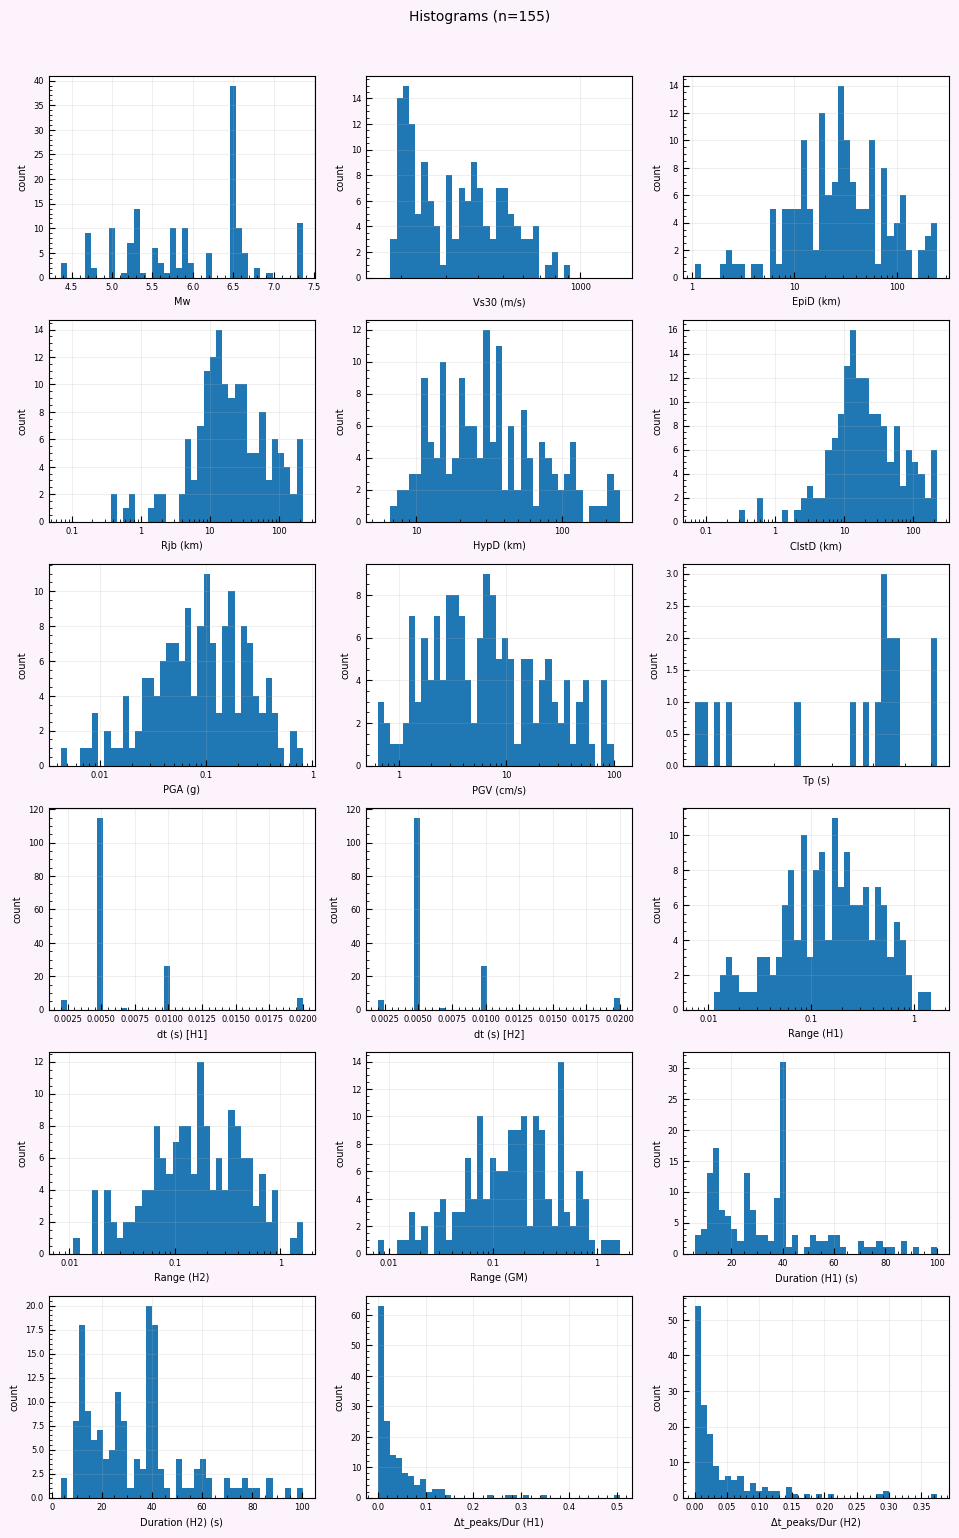

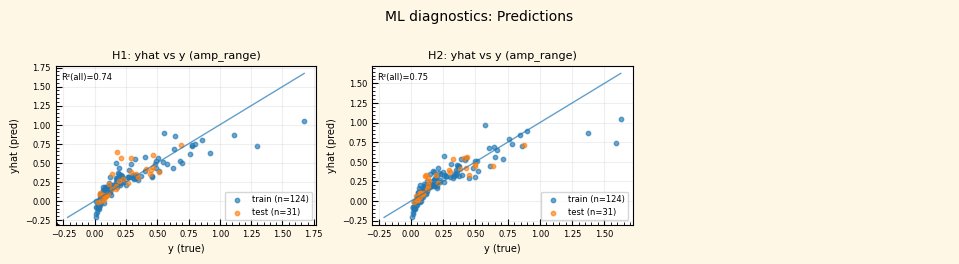

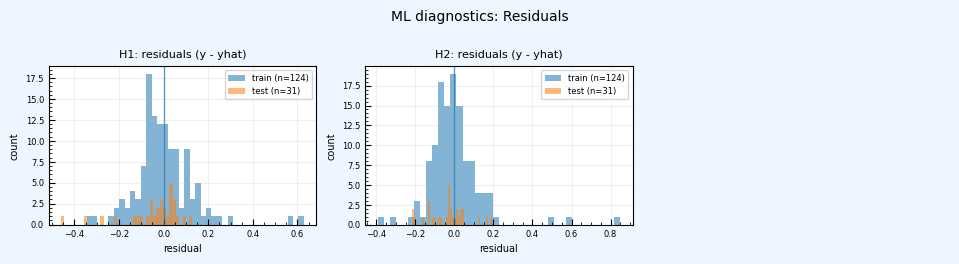

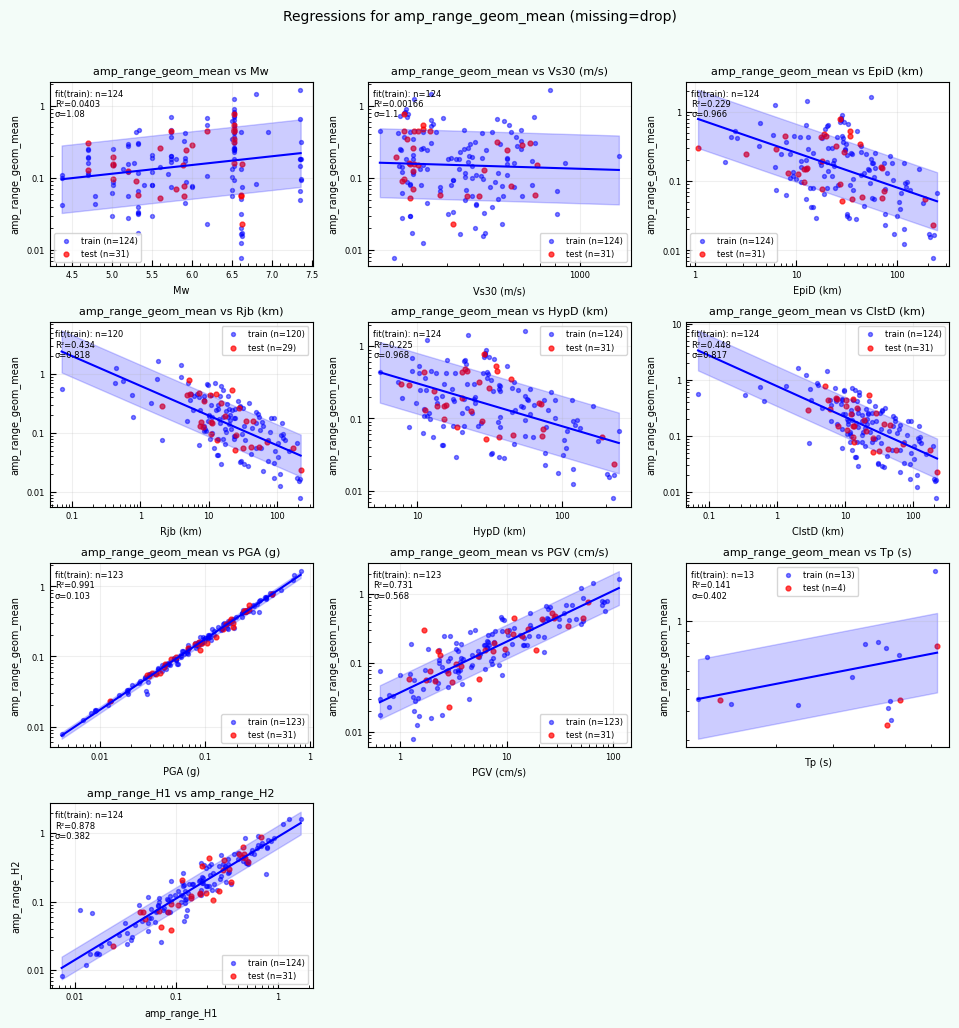

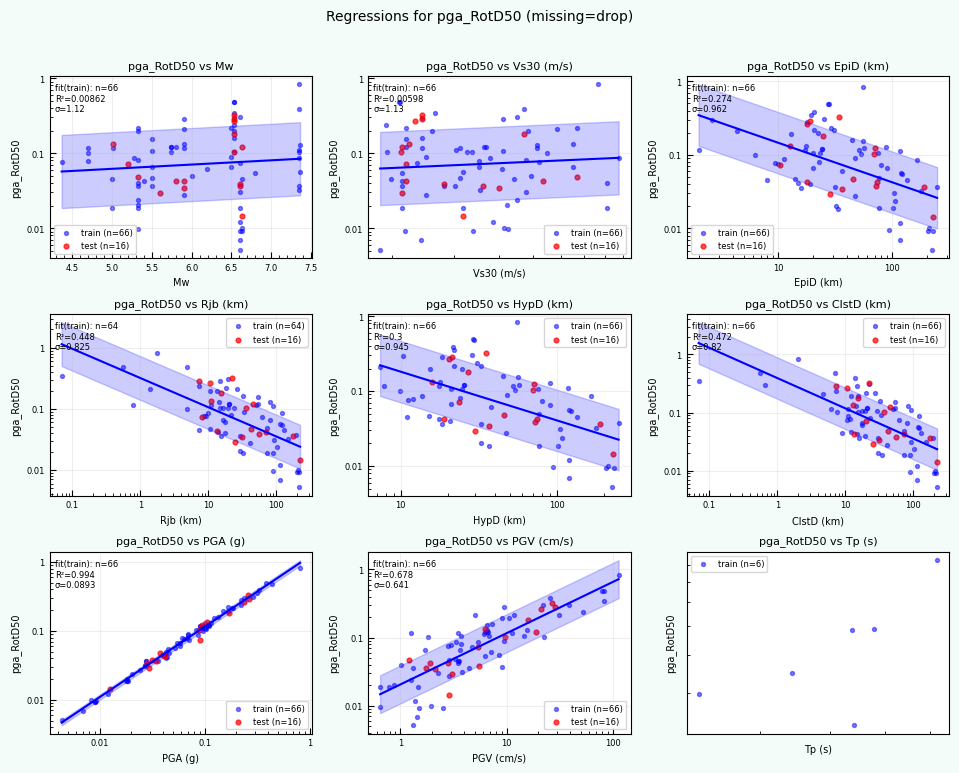

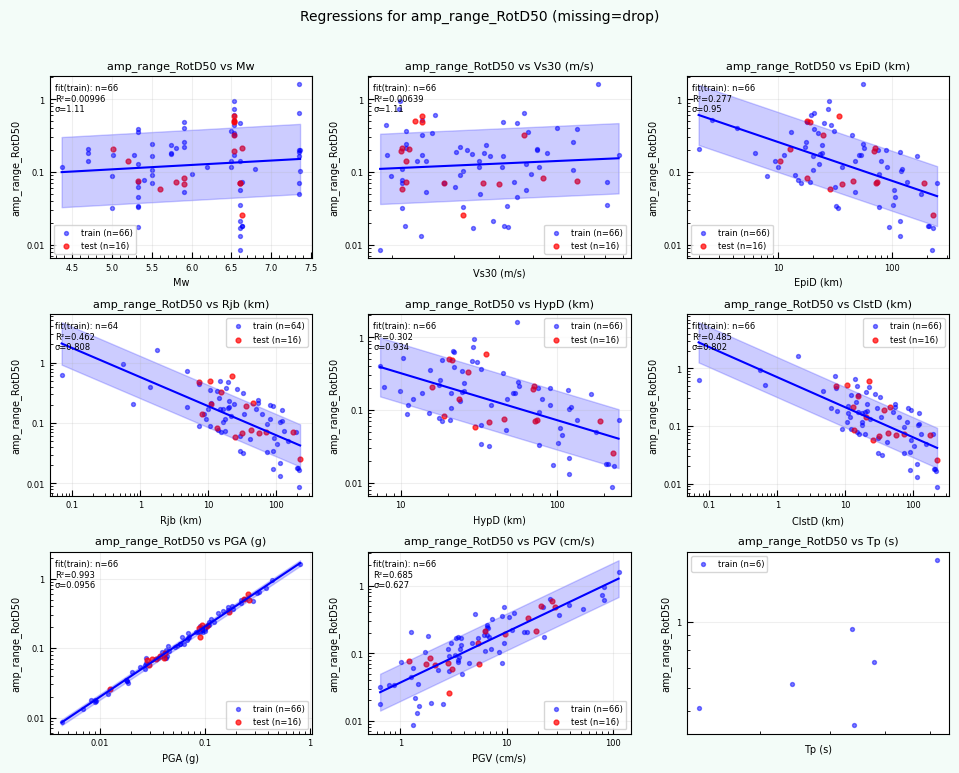

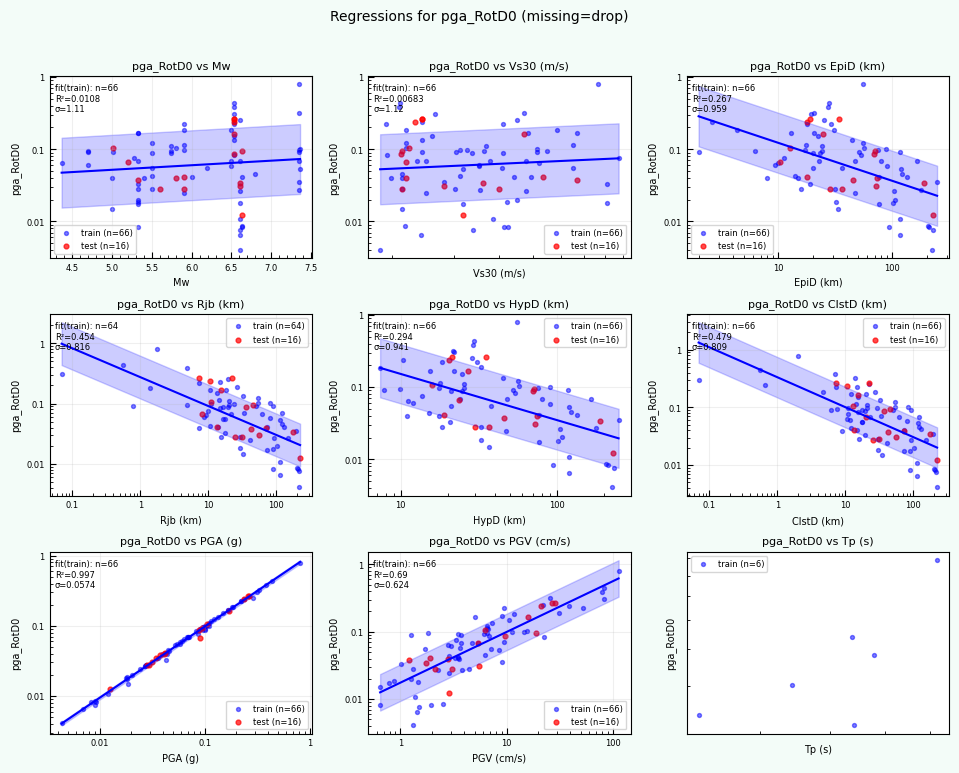

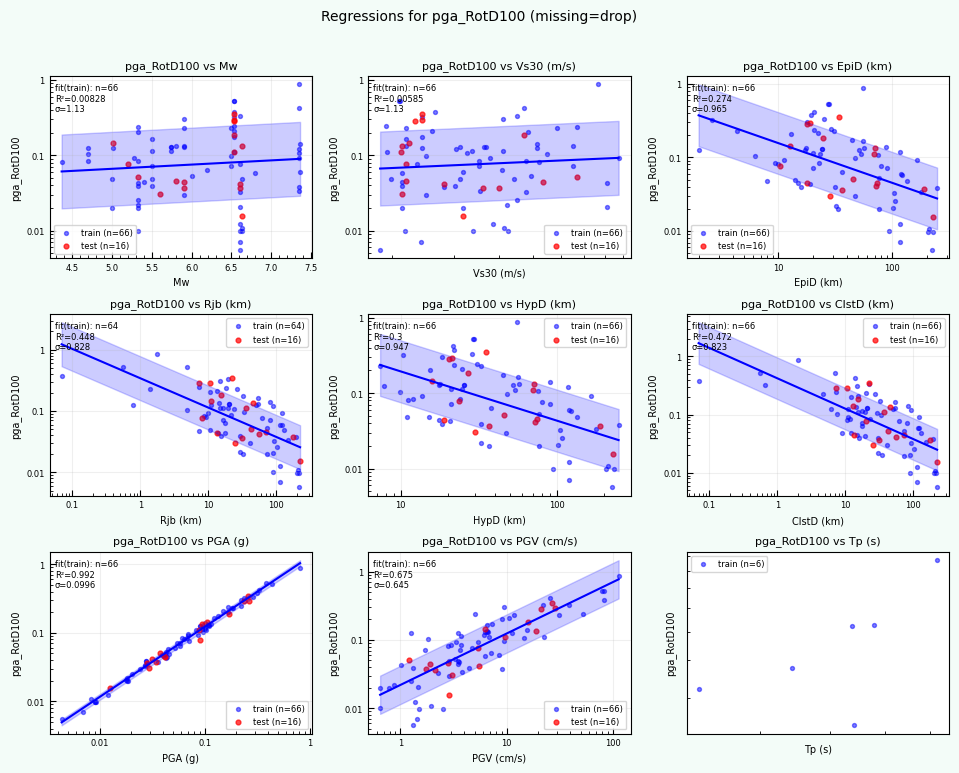

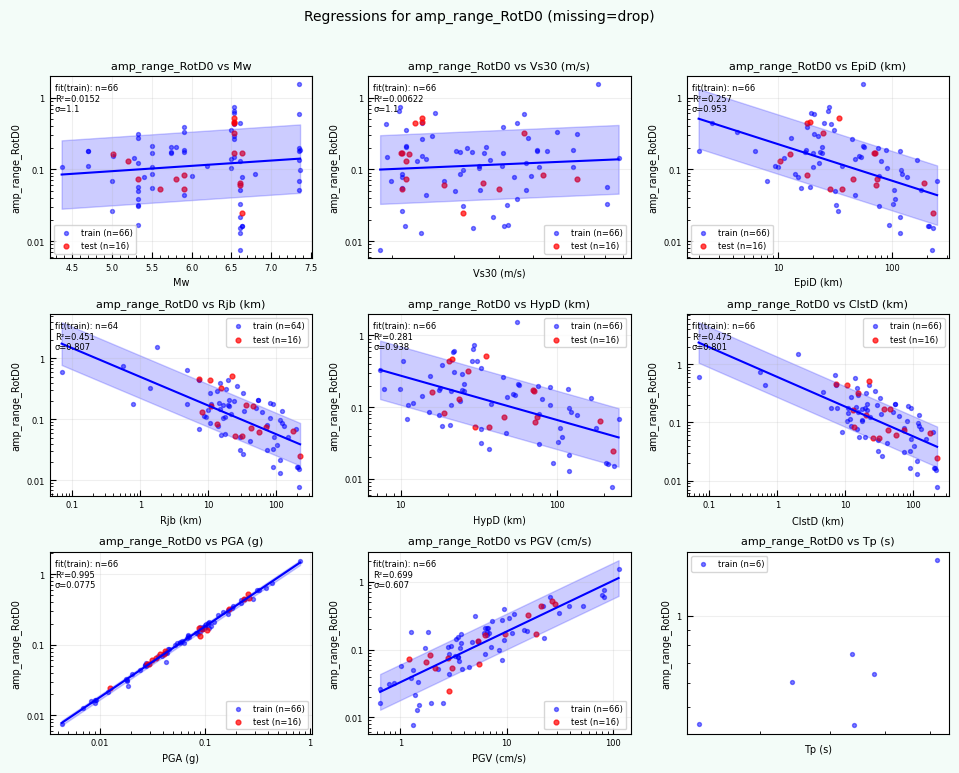

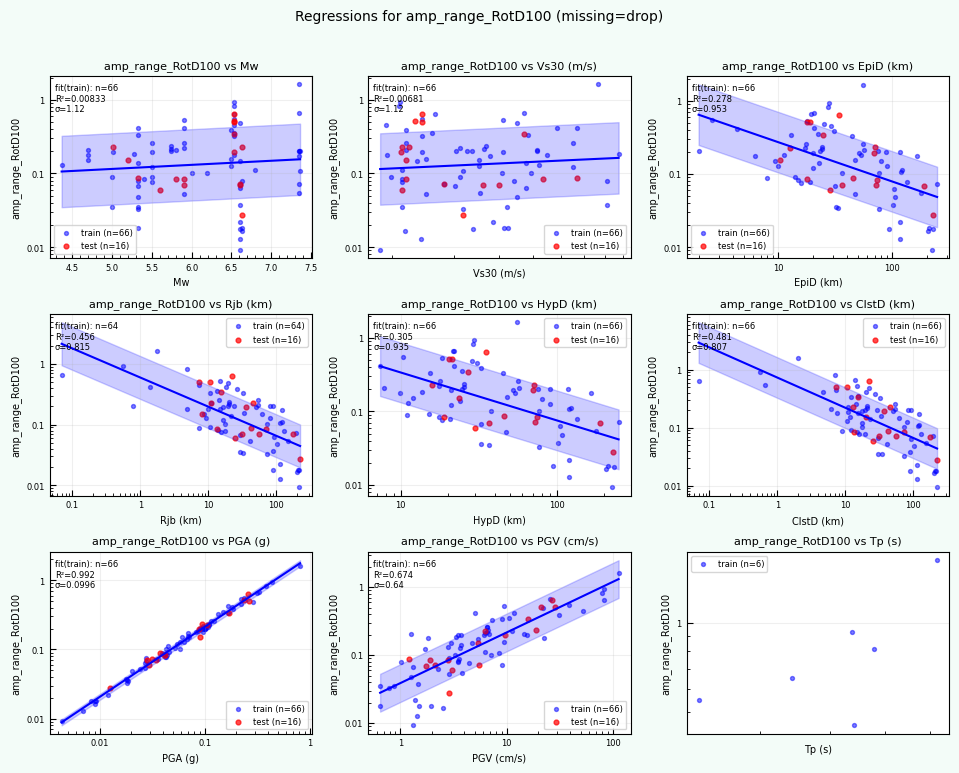

Wrote: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory/out_process_postProcessed/NGAWest2_summary_plots.pdf
return code: 0
Post-processed outputs in: out_process_postProcessed


In [50]:
# -------------------------
# Post-processing settings
# -------------------------
workdir = outDir                 # outputs from the MPI run
outdirPost = f"{outDir}_postProcessed"

# What to analyze/plot
targetMetric = "amp_range_geom_mean"
ncols = 3
subplot_w = 3.2
subplot_h = 2.6

# If your metrics use sentinel values for missing data, keep consistent with your postprocessor defaults.
# Otherwise, you can omit this.
sentinels = [-999.0]

# -------------------------
# Import + reload (so edits to the module take effect)
# -------------------------
import importlib
import postprocess_nga_metrics_ml  # or your module name
## we are using importlib.reload so that you can edit the post-processing file without having to rerun the full notebook, you can just re-run this cell.
importlib.reload(postprocess_nga_metrics_ml)

# -------------------------
# Run
# -------------------------
args = [
    "--prefix", outPrefix,
    "--workdir", workdir,
    "--outdir", outdirPost,
    "--target", targetMetric,
    "--ncols", str(ncols),
    "--subplot-w", str(subplot_w),
    "--subplot-h", str(subplot_h),
    "--show",
]

# Add sentinel(s) only if your script supports --sentinel (many do)
# args += ["--sentinel"] + [str(s) for s in sentinels]

rc = postprocess_nga_metrics_ml.main(args)
print("return code:", rc)
print("Post-processed outputs in:", outdirPost)


### **REMEMBER, YOU ARE IN THE JOB-OUTPUT FOLDER**
### YOU CAN CHOOSE THE DATA YOU WOULD LIKE TO MOVE TO YOUR PROJECT.
I recommend moving files manually in Jupyter Hub, either using the terminal commands or using the file browswer on the left panel.

In [51]:
print(f"Current directory: {os.getcwd()}")

Current directory: /home/jupyter/MyData/tapis-jobs-archive/2026-02-09Z/7c68e901-a909-4491-a0de-9bb5780d907f-007/inputDirectory


In [52]:
print('done!')

done!
